In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from fast_slic import Slic
%matplotlib inline
plt.rcParams["figure.figsize"] = (80,20)
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage


In [26]:
def reduce_superpixel(seeds_bg, seeds_fg, assignment):
    # seeds_bg: List with points that belong to the background class
    # seeds_fg: List with points that belong to the foreground class
    # assignment: Superipixel assignment as produced by e.g. SLIC
    #
    # Assigns each superpixel in assignment a label [foreground, background, None] based on majority voting of seeds in it 
    # Resulting assignment will have the following labeling:
    # 0 -> Background
    # 1 -> No label
    # 2 -> Foreground
    
    # How many superpixels are there
    max_points = np.max(assignment) + 1
    
    # For each superpixel, store how many foreground - background votes it received
    accounting = np.zeros(max_points)
    
    for pointX,pointY in seeds_bg:
        # Get Superpixel
        superpixel_label = assignment[pointX,pointY];
        # Increase Vote by 1
        accounting[superpixel_label] = accounting[superpixel_label] + 1
    
    for pointX,pointY in seeds_fg:
        # Get superpixel
        superpixel_label = assignment[pointX,pointY];
        # Decrease Vote by 1
        accounting[superpixel_label] = accounting[superpixel_label] - 1
        
    for i in range(max_points):
        assignment[assignment == i] = (np.sign(accounting[i]) + 1)
        
    return assignment

In [27]:
def plot_reduced_sp(seeds_bg, seeds_fg, assignment, original):
    # Plots everything used to generate the labels
    
    plt.subplot(3,3,1)
    plt.imshow(mark_boundaries(original, assignment))
    assign = reduce_superpixel(seeds_bg, seeds_fg, assignment)
    plt.subplot(3,3,2)
    plt.imshow(to_rgb_mask(assign))
    plt.subplot(3,3,3)
    plt.imshow(mark_boundaries(original, assign))
    
    plt_cnt = 0
    for i in (class_background, class_foreground, class_unknown):
        plt.subplot(3,3,3 + plt_cnt)
        plt.imshow(assign == i)
        plt_cnt = plt_cnt + 1
    plt.subplot(3,3,6)
    plt.imshow(np.multiply(original, np.stack([assign == class_background, assign == class_background, assign==class_background],axis = -1)))
    plt.title("background")
    plt.subplot(3,3,7)
    plt.imshow(np.multiply(original, np.stack([assign == class_foreground, assign == class_foreground, assign==class_foreground],axis = -1)))
    plt.title("foreground")
    plt.subplot(3,3,8)
    plt.imshow(np.multiply(original, np.stack([assign == class_unknown, assign == class_unknown, assign==class_unknown],axis = -1)))
    plt.title("unknown")

In [28]:
def to_rgb_mask(mask):
    # Converts a labels mask to RGB to better see which pixel is what class
    mask_r = (mask == class_background) * 255
    mask_g = (mask == class_foreground) * 255
    mask_b = (mask == class_unknown) * 255
    return Image.fromarray(np.uint8(np.stack([mask_r, mask_g, mask_b], axis = -1)))

In [29]:
def get_preview_image(original, binary_mask):
    # Projects the labels mask on a rgb image
    img = to_rgb_mask(binary_mask)
    img.putalpha(50)
    new_img = original.copy()
    new_img.paste(img, (0, 0), img)
    return new_img;

In [30]:
# Threshold between foreground and background. 
# Labels have values [1,255] where 1 means the point is really close to the mesh and 255 means the point is really far away from  a mesh
# a threshold of 100 means all points with distance value > 100 will be assigned to "foreground" label
fg_bg_threshold = 100;

class_background = 0;
class_unknown = 1;
class_foreground = 2;


In [31]:
def convert_file_path_to_gt(label, original, distance, outfolder, resize = True, useSuperpixel = True, onlyPlotResults = False):
    # label: Path to label file as generated by ros node
    # original: Path to original image
    # distance: Path to distance Imag as generated by rose node. TODO use this to refine superpixel aswell as to generate distance labels
    # resize: Wether to resize the images -> Better performance for SLIC
    # userSuperpixel: Wether to user Superixel or watershed algorithm
    #
    # Converts the given sparse labels into a aggregated form and stores it in outfolder
    
    original = Image.open(original)
    labels = Image.open(label)
    distance = Image.open(distance)
    
    if resize:
        original = original.resize((original.width // 2, original.height // 2), Image.ANTIALIAS)
        labels = labels.resize((labels.width // 2, labels.height // 2), Image.NONE)
        distance = distance.resize((distance.width // 2, distance.height // 2), Image.NONE)
    
    np_orig = np.asarray(original)
    np_labels = np.asarray(labels)
    # Foreground Labels
    np_labels_foreground = np_labels > fg_bg_threshold 
    # Background Labels
    np_labels_background = np.logical_and(np_labels < fg_bg_threshold, np_labels > 0) 
    # No Labels
    np_no_labels = np_labels == 0
    
    # Create a list containing all points that were assigned background
    seeds_bg = [(c[0],c[1]) for c in np.asarray(np.where(np_labels_background > 0)).T]
    # Create a list containing all points that were assigned foreground
    seeds_fg = [(c[0],c[1]) for c in np.asarray(np.where(np_labels_foreground > 0)).T]
    
    
    if useSuperpixel:
        #superpixels = slic.iterate(np_orig)
        superpixels = skimage.segmentation.slic(np_orig, n_segments=1000, compactness=4, sigma=1, start_label=1)
        
        if onlyPlotResults:
            plot_reduced_sp(seeds_bg, seeds_fg, superpixels, original)
            return
        
        mask = reduce_superpixel(seeds_bg,seeds_fg, superpixels)
    else:
        markers = np.zeros(np_labels_foreground.shape, dtype=np.uint)
        markers[np_labels_foreground] = 1
        markers[np_labels_background] = 2
        # Run watershed on canny edge filtered image.
        mask = watershed(feature.canny(rgb2gray(np_orig),sigma=0.1), markers)
        
    Image.fromarray(np.uint8(mask), 'L').save(outfolder + "semseg.png")
    get_preview_image(original, mask).save(outfolder + "preview.png")
    

## Main Program

In [33]:
from os import listdir
import os
from os.path import isfile, join

working_dir = "/home/rene/cla_dataset/cam0/"
output_dir = "/home/rene/cla_dataset/cam0_preprocessed"

# Copy all images int this list
image_folders = [f for f in listdir(working_dir)  if ".txt" not in f]

# Sort by timestamp as they will be remapped to img_001, img_002,...
image_folders = sorted(image_folders, key=float, reverse = False)

files_labels = [ f + "/labels.png" for f in image_folders]
files_preview = [ f + "/preview.png" for f in image_folders]
files_distance = [f + "/distance.png" for f in image_folders]
files_original = [f + "/original.png" for f in image_folders]


In [ ]:
# Extracts mapping from previous image name (timestamp) to new image name (number)
timestamp_number_mapping = ""
for j,k in enumerate(image_folders):
    timestamp_number_mapping += str(j)+ "," + str(k) +";\n"
    
try:
    os.mkdir(output_dir)
except OSError:
    pass
    
f = open("/home/rene/cla_dataset/cam0_preprocessed/info.txt", "w")
f.write(timestamp_number_mapping)
f.close()

# Convert labels

cnt = 1;
for i in range(len(files_labels)):
    file = files_labels[i]
    print("[", cnt , "/",len(files_labels),"]  -   " ,file, end="\r")
    cnt += 1
    try:
        os.mkdir(output_dir+"/img_"+str(i))
    except OSError:
        pass
    # Convert labels
    convert_file_path_to_gt(working_dir + files_labels[i], working_dir+files_original[i], working_dir + files_distance[i], output_dir+"/img_"+str(i)+"/")

## Plot some results

/home/rene/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


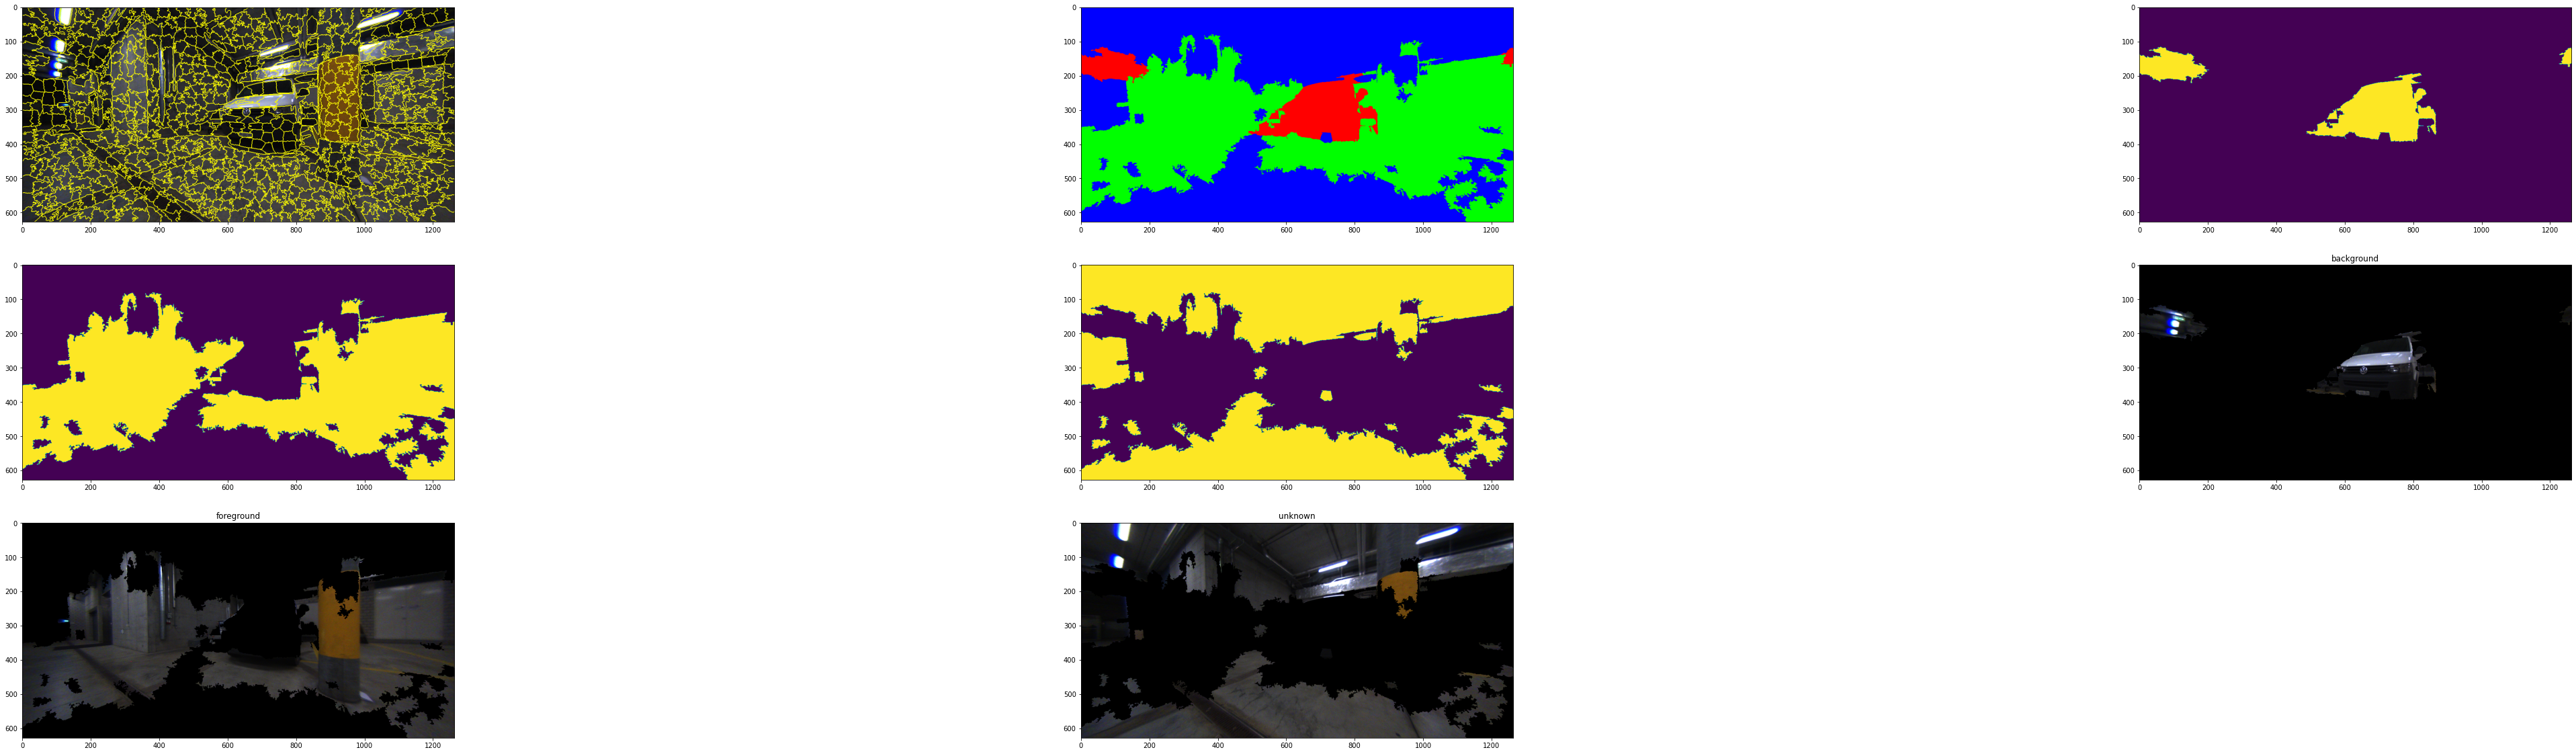

In [35]:
i = 0
file = files_labels[i]
convert_file_path_to_gt(working_dir + files_labels[i], working_dir+files_original[i], working_dir + files_distance[i], output_dir+"/img_"+str(i)+"/", onlyPlotResults = True)

## Debugging Stuff

/home/rene/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


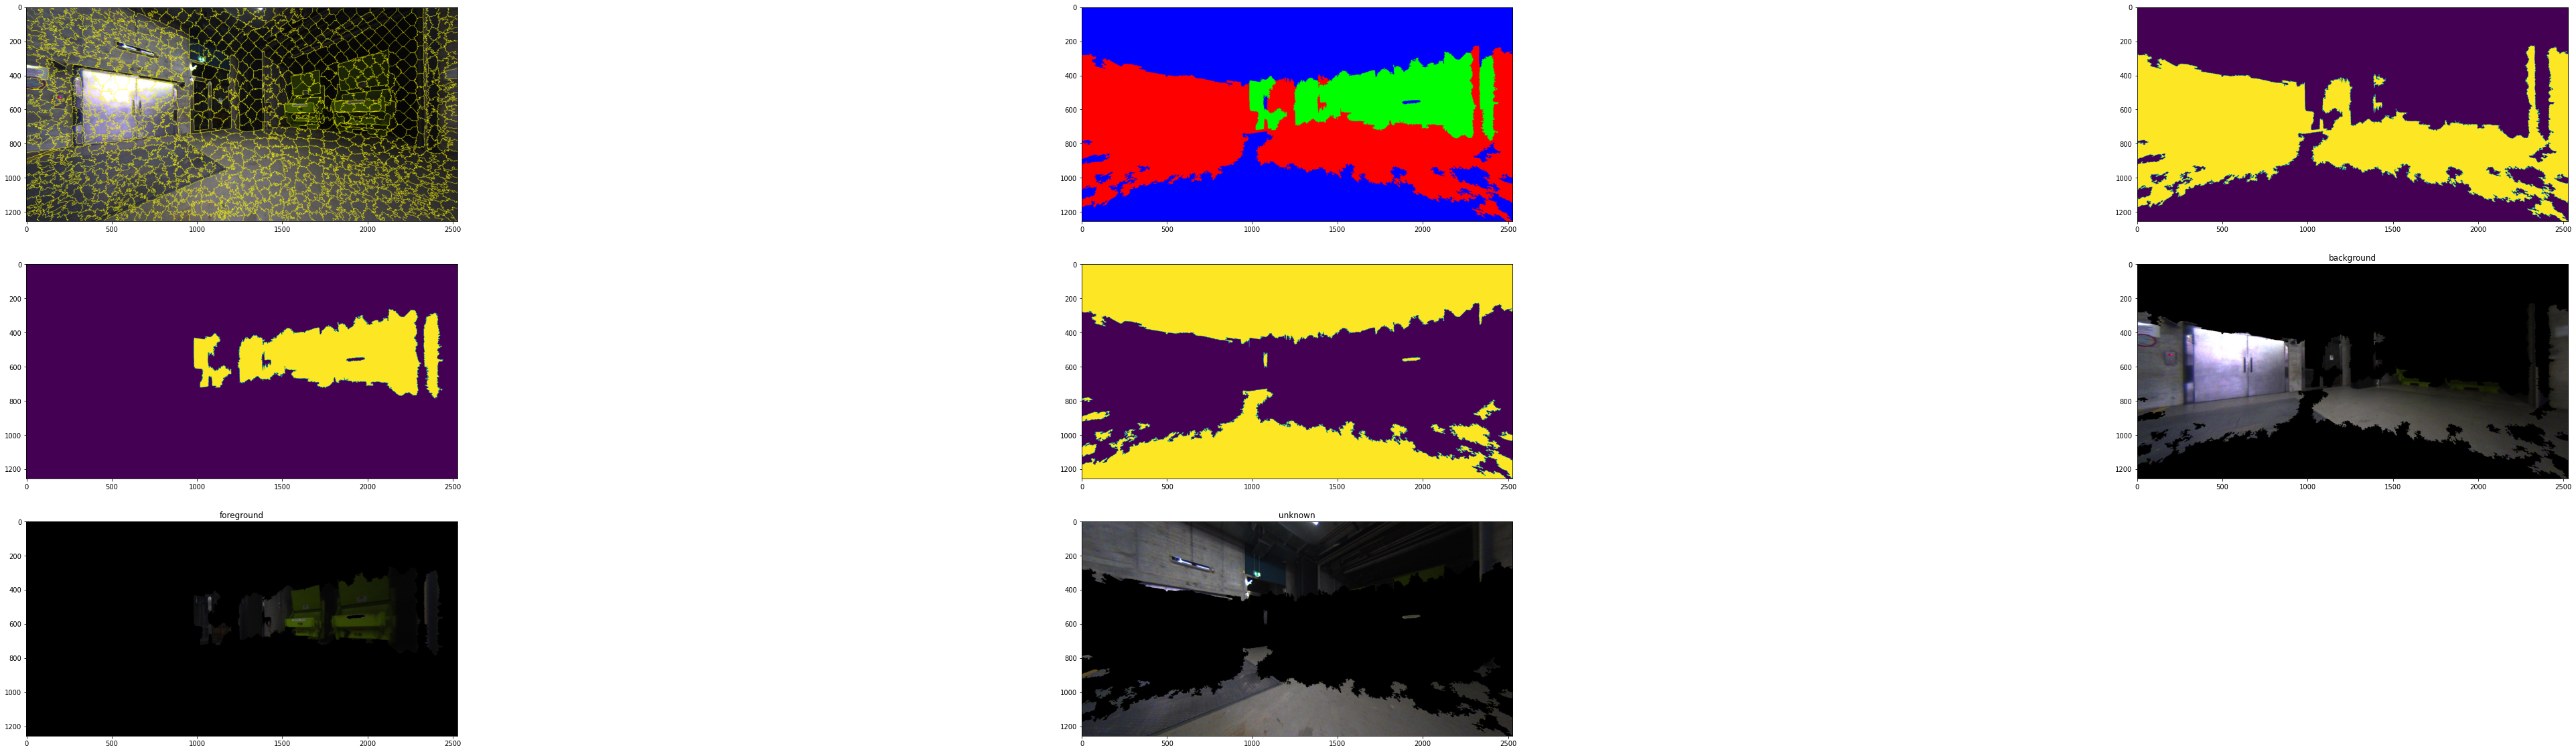

In [213]:
import skimage as skimage

img = img_as_float(np_orig)

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = skimage.segmentation.slic(img, n_segments=1000, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

/home/rene/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


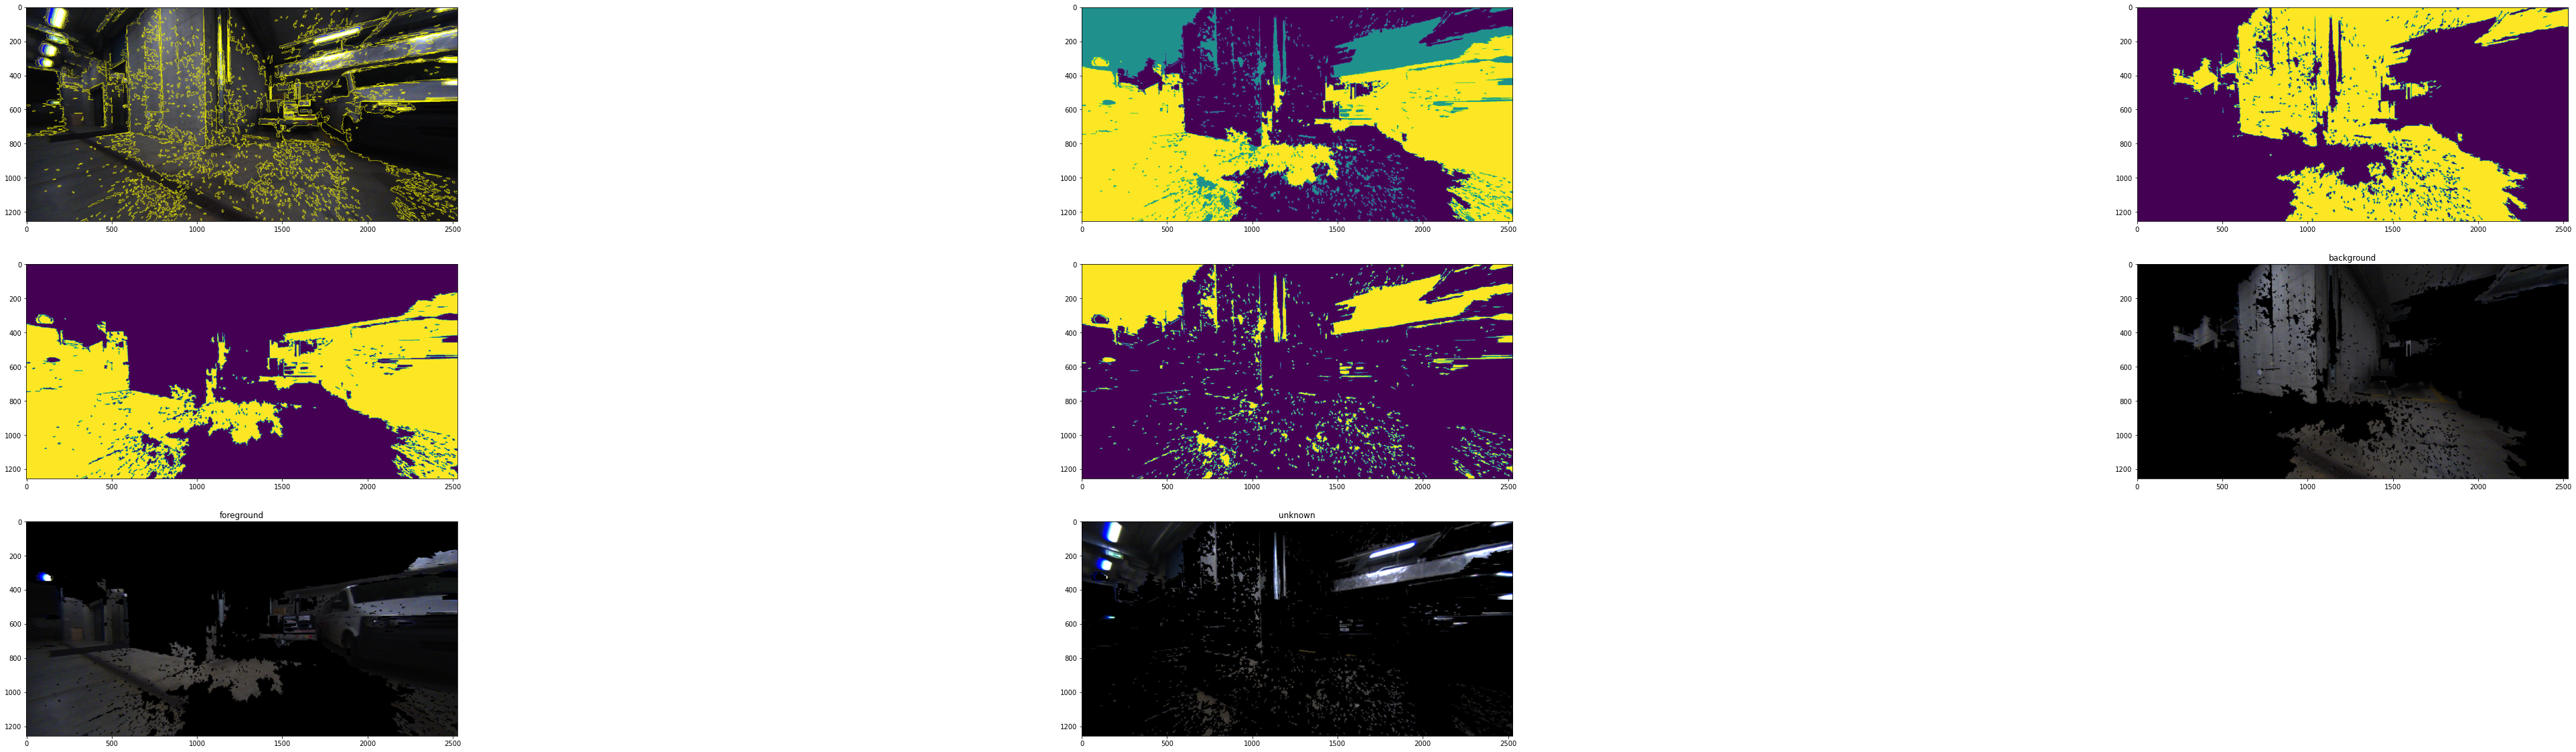

In [201]:
plot_reduced_sp(seeds_bg, seeds_fg, segments_fz)

/home/rene/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


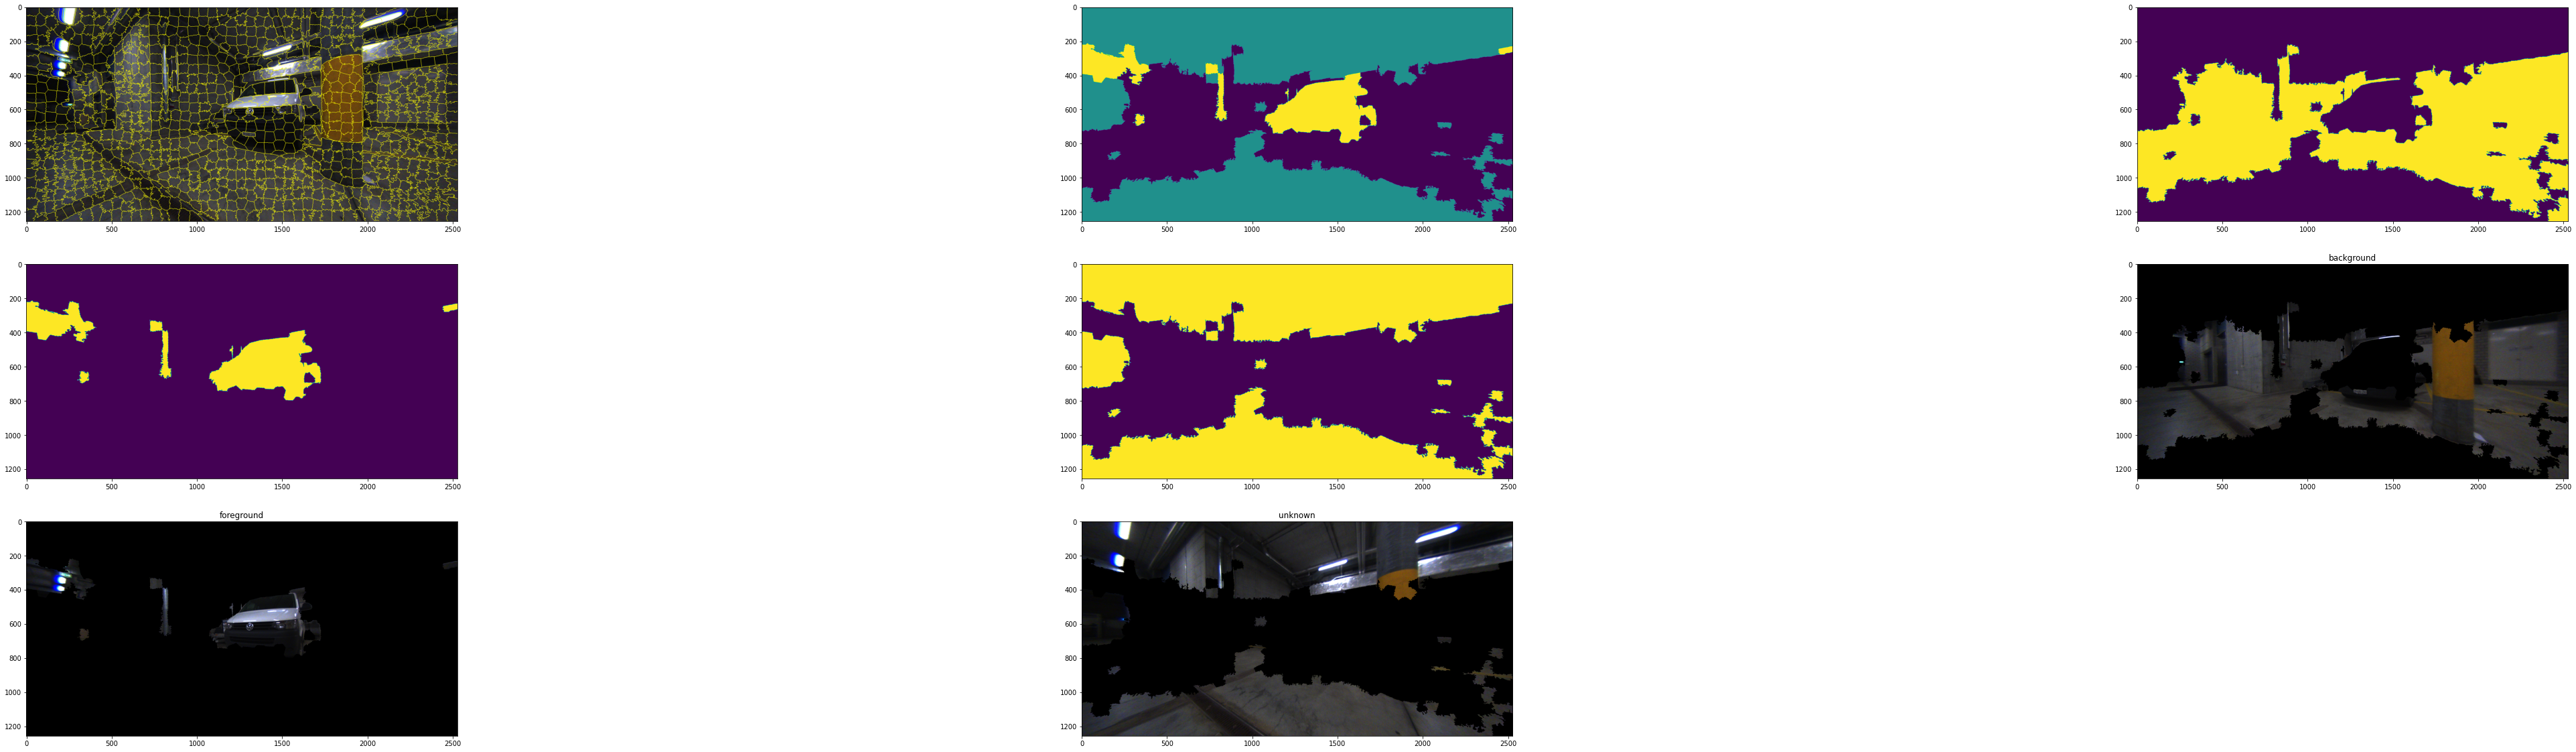

In [214]:
plot_reduced_sp(seeds_bg, seeds_fg, segments_slic)

/home/rene/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


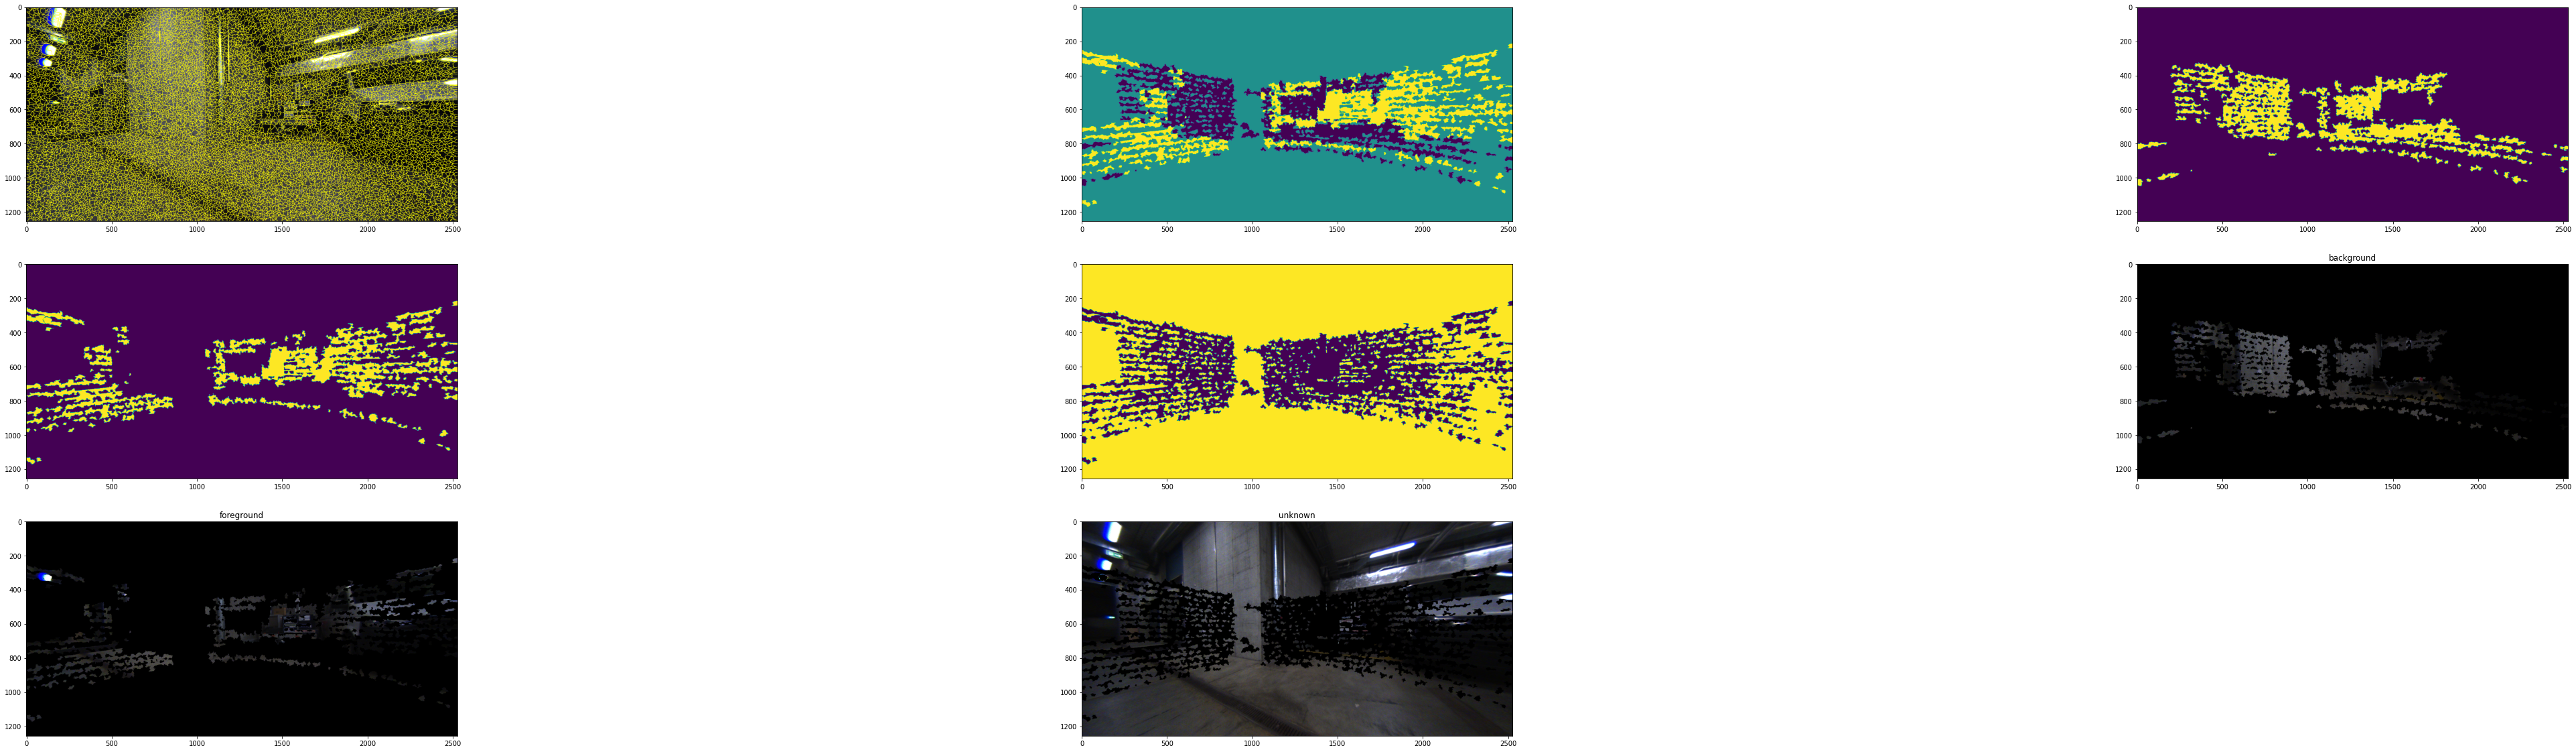

In [203]:
plot_reduced_sp(seeds_bg, seeds_fg, segments_quick)